# ***Adding requirement for attention layer***

In [1]:
'''from shutil import copyfile
copyfile(src = "../input/attention/attention.py", dst = "../working/attention.py")'''

'from shutil import copyfile\ncopyfile(src = "../input/attention/attention.py", dst = "../working/attention.py")'

# ***importing required libraries***

In [2]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
from attention_keras.layers.attention import AttentionLayer
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
from keras import backend as K
from keras.models import load_model
K.clear_session()

Using TensorFlow backend.


# ***Loading dataset to the notebook***

In [3]:
data=pd.read_csv("/home/singhabhi/Reviews.csv")[:100000]

# ***Dropping duplicate reviews and null values***

In [4]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

# ***Information about datatypes and shape of the dataset***

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      88421 non-null  int64 
 1   ProductId               88421 non-null  object
 2   UserId                  88421 non-null  object
 3   ProfileName             88421 non-null  object
 4   HelpfulnessNumerator    88421 non-null  int64 
 5   HelpfulnessDenominator  88421 non-null  int64 
 6   Score                   88421 non-null  int64 
 7   Time                    88421 non-null  int64 
 8   Summary                 88421 non-null  object
 9   Text                    88421 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


# ***Dictionary for expanding the contractions***

In [6]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

# ***For removing stopwords***

In [7]:
stop_words = set(stopwords.words('english')) 

# ***Function for cleaning reviews and summaries***

In [8]:
def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

# ***cleaning reviews and displaying***

In [9]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))
cleaned_text[:5]  

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

# ***cleaning summaries and displaying***

In [10]:
#call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

# ***Adding columns into the dataset***

In [11]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

# ***Dropping empty rows***

In [12]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

# ***Visualization distribution of reviews and summaries***

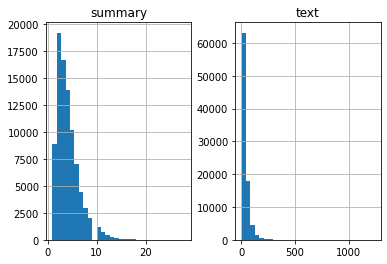

In [13]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [14]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=10):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9788683772679426


In [15]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=80):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.9076637502688142


In [16]:
max_text_len=80
max_summary_len=10

# ***getting rid of outliers***

In [17]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

# ***Adding tokens at the beginning and the end of summary***

In [18]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [19]:
for i in range(5):
    print("Review:",df['text'][i])
    print("Summary:",df['summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: sostok good quality dog food eostok


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: sostok not as advertised eostok


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: sostok delight says it all eostok


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: sostok cough medicine eostok


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lover 

# ***splitting traing and test set***

In [20]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

# ***prepare a tokenizer for reviews on training data***

In [21]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

# ***calculating number of rare and common words in reviews***

In [22]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 64.82162778001947
Total Coverage of rare words: 1.736668392441108


# ***defining tokenizer with most common words for reviews***

In [23]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [24]:
x_voc

14822

# ***prepare a tokenizer for summaries on training data***

In [25]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

# ***calculating number of rare and common words in summaries***

In [26]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 75.71924411878133
Total Coverage of rare words: 3.9229166320949957


# ***defining tokenizer with most common words for summaries***

In [27]:
#prepare a tokenizer for summaries on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

# ***checking word count of start token is equal to length of the training data***

In [28]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(72173, 72173)

# ***deleting the rows that contain only START and END tokens***

In [29]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [30]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# ***Model building, defining LSTM layers, Encoder and Decoder***

In [59]:
from tensorflow.keras.models import model_from_json
# Model reconstruction from JSON file
with open('/home/singhabhi/Downloads/summarization/model.json', 'r') as f:
    model = model_from_json(f.read(),custom_objects={'AttentionLayer':AttentionLayer})

In [65]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [66]:
model.load_weights('/home/singhabhi/Downloads/summarization/model.h5')

[array([[ 0.06474411, -0.09531225,  0.02276673, ...,  0.08010434,
         -0.00619397, -0.0635604 ],
        [-0.01440849, -0.0033414 ,  0.0037362 , ...,  0.00875186,
          0.01057385, -0.01759978],
        [-0.01707516, -0.02241674,  0.00816982, ...,  0.04438147,
         -0.01812486, -0.04457953],
        ...,
        [ 0.04186633, -0.02027748, -0.01012327, ...,  0.02491053,
         -0.02253675, -0.04267329],
        [ 0.01076787,  0.05915055,  0.01309771, ...,  0.04157045,
          0.05813583, -0.00629552],
        [ 0.04065908,  0.03699409,  0.03262031, ..., -0.01420193,
          0.04998899, -0.03585323]], dtype=float32)]

In [69]:
'''from tensorflow.keras.models import load_model

model = load_model('/home/singhabhi/Downloads/summarization/summary(1).h5',
                   custom_objects={'AttentionLayer':AttentionLayer})'''

"from tensorflow.keras.models import load_model\n\nmodel = load_model('/home/singhabhi/Downloads/summarization/summary(1).h5',\n                   custom_objects={'AttentionLayer':AttentionLayer})"

# ***monitoring the validation loss***

# ***train the model on a batch size of 512 and validate it on the 10% of dataset***

In [70]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 100)      1467000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [71]:
from keras import backend as K

#inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]      # all layer outputs
#functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions

In [48]:
model.layers

In [72]:
model.layers

In [73]:
#Encoder
encoder_inputs = outputs[0]

#embedding layer
enc_emb = outputs[1]

#encoder lstm 1
encoder_lstm1 = model.layers[2]
encoder_output1, state_h1, state_c1 = outputs[2]

#encoder lstm 2
encoder_lstm2 = model.layers[4]
encoder_output2, state_h2, state_c2 = outputs[4]
#encoder lstm 3
encoder_lstm3 = model.layers[6]
encoder_outputs, state_h, state_c = outputs[6]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = outputs[3]

#embedding layer
dec_emb_layer = model.layers[5]
dec_emb = outputs[5]

decoder_lstm = model.layers[7]
decoder_outputs,decoder_fwd_state, decoder_back_state = outputs[7]

# Attention layer
attn_layer = model.layers[8]
attn_out, attn_states = outputs[8]

# Concat attention input and decoder LSTM output
decoder_concat_input = outputs[9]

#dense layer
decoder_dense = model.layers[10]
decoder_outputs = outputs[10]

In [74]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# ***understanding the behavior of model over time***

In [75]:
latent_dim = 300
embedding_dim=100

In [76]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

# ***convert the index to word for summaries and reviews vocabulary***

In [77]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

# ***Setting up the inference for the encoder and decoder***

# ***Defining a functio for implementation of the inference process***

# ***converting an integer sequence to a word sequence for summaries and reviews***

In [78]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

# ***displaying some summaries generated by the model***

In [79]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: want reviewers noted poor quality cups half cups purchased explode coffee machine foil top cup sealed properly disappointing waste money real pain clean machine explosion coffee grounds unfortunate think tully best quality coffee particularly decaf find cups right heard starbucks going get cup business point hopefully sooner later 
Original summary: good tasting coffee poor quality cups 
Predicted summary:  great like


Review: nothing product anywhere compares cope corn always served home holidays thanksgiving christmas easter loved corn pudding one thing dried corn pudding something completely different quite wonderful cannot find anywhere grocery stores thought maybe produced anymore looked line wow happy serving thanksgiving year cannot wait 
Original summary: wonderful of kind 
Predicted summary:  great to


Review: special chocolatey pieces little waxy tasting cutting extra chocolate great substitute 
Original summary: yumm 
Predicted summary:  great to


Review: love fam

Predicted summary:  what ketchup


Review: looked citric acid use cheese making could find decent price citric acid sold local health food store much less expensive free shipping topped great deal thank amazon 
Original summary: best citric acid available 
Predicted summary:  great to


Review: seeds grow perfectly easy sprouter cup seeds days make full cups without give energy like radishes radishes overwhelm suttle flavors would like without radish touch radish perfect food someone loves radishes tried salads stews spaghetti sauce great eggs cheese sandwiches even radish taste 
Original summary: good if you like 
Predicted summary:  great treat


Review: far decaf kcups tried favorite wish automatic ordering system coffee individual like dislike use oz cup water great 
Original summary: great coffee 
Predicted summary:  great to


Review: first found popcorn local costco far best bagged popcorn mix ever contact cretors informed would amazon cannot wait taste become fan 
Original summ

Predicted summary:  and coffee favorite


Review: big happybaby fans flavor pouch one favorites son two tried make baby food first introducing solids trouble finding fresh organic fruits vegetables certain times year apricot one would never thought combine apricots sweet potatoes combination works love really nutrient dense easy snack go son picky eater phase pouches help get veggies also think pouch reason behind current love dried apricots overall great flavor combination super nutritious food little ones find pouches runny like mentioned fyi 
Original summary: great flavor combination 
Predicted summary:  the out one taste the and


Review: lately really getting espresso small espresso based energy drink comes close taste real thing possible drink kind light bitter compared similar beverages instance ounce starbucks doubleshot contains sugar fat calories even starbucks doubleshot light sugar fat calories terms caffeine per serving illy espresso drink mg opposed drinks bottom line wa

Predicted summary:  not for me


Review: heaven forbid run usually order one box time dogs small always buy lite teenie greenies dogs love much anything ask get one come call matter think get greenie reward give one two little dogs greenie everynight bedtime know routine well till one runs bed actually opens kennel door paws waits greenie never seen dog yet love greenies even almost toothless year old schnauzer loves greenies 
Original summary: my dogs go crazy for these 
Predicted summary:  my snack love these


Review: reluctant try velveeta skillets dinner kit cannot stand hamburger helper product reminded however really surprised much liked box meal bursting flavor unlike box meals really taste ingredients cheese broccoli chicken velveeta brand box meals best tried thus far really simple make make good size dinner portion price cannot go wrong velveeta chicken broccoli skillets dinner kit hit family well waiting go buy one today disappointed 
Original summary: move over hamburger h